## BREAST CANCER PREDICTION - NEURAL NETWORK MODEL

#### Load the required libraries

#### Also ensure the kernel is _pytorch_p36

In [1]:
# data managing and display libs
import pandas as pd
import numpy as np
import os
import io

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [2]:
# sagemaker libraries
import boto3
import sagemaker
from sagemaker import get_execution_role
from sagemaker.pytorch import PyTorch

In [36]:
# torch imports
import torch
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch import nn, optim

#### Set up the Sagemaker Environment

In [3]:
# sagemaker session, role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
print(role)

# S3 bucket name
bucket = sagemaker_session.default_bucket()
print(bucket)

arn:aws:iam::396358375665:role/service-role/AmazonSageMaker-ExecutionRole-20200814T112856
sagemaker-eu-west-1-396358375665


#### Read the PCA data

In [4]:
# read in the pca csv file
local_data = 'data/pca.csv'

# print out some data
pca_bc_df = pd.read_csv(local_data)
print('Data shape (rows, cols): ', pca_bc_df.shape)
print()
pca_bc_df.head()

Data shape (rows, cols):  (569, 13)



,id,id.1,diag_value,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10
0,842302,842302,1,-9.192838,-1.948583,1.123166,-3.633731,-1.195110,-1.411424,-2.159370,-0.398406,0.157118,0.877402
1,842517,842517,1,-2.387802,3.768172,0.529293,-1.118264,0.621775,-0.028657,-0.013358,0.240989,0.711905,-1.106994
2,84300903,84300903,1,-5.733896,1.075174,0.551748,-0.912083,-0.177086,-0.541452,0.668167,0.097373,-0.024066,-0.454275
3,84348301,84348301,1,-7.122953,-10.275589,3.232790,-0.152547,-2.960879,-3.053421,-1.429910,1.059565,1.405438,1.116976
4,84358402,84358402,1,-3.935302,1.948071,-1.389767,-2.940639,0.546748,1.226494,0.936212,0.636376,0.263806,-0.377705


In [5]:
# tidy up the columns and index

pca_bc_df = pca_bc_df.drop('id.1', axis = 1)
pca_bc_df.index=pca_bc_df['id'] 
pca_bc_df = pca_bc_df.drop('id', axis = 1)
pca_bc_df.head()

,diag_value,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10
id,,,,,,,,,,,
842302,1,-9.192838,-1.948583,1.123166,-3.633731,-1.195110,-1.411424,-2.159370,-0.398406,0.157118,0.877402
842517,1,-2.387802,3.768172,0.529293,-1.118264,0.621775,-0.028657,-0.013358,0.240989,0.711905,-1.106994
84300903,1,-5.733896,1.075174,0.551748,-0.912083,-0.177086,-0.541452,0.668167,0.097373,-0.024066,-0.454275
84348301,1,-7.122953,-10.275589,3.232790,-0.152547,-2.960879,-3.053421,-1.429910,1.059565,1.405438,1.116976
84358402,1,-3.935302,1.948071,-1.389767,-2.940639,0.546748,1.226494,0.936212,0.636376,0.263806,-0.377705


#### Split the data into Train and Test

In [7]:
# split into train/test
def train_test_split(df, train_frac= 0.7, seed=1):
    '''Shuffle the data and randomly split into train and test sets;
       separate the class labels (the column in df) from the features.
       :param df: Dataframe of all TNA measurements
       :param train_frac: The decimal fraction of data that should be training data
       :param seed: Random seed for shuffling and reproducibility, default = 1
       :return: Two tuples (in order): (train_features, train_labels), (test_features, test_labels)
       '''
    # convert dataframe to a matrix in order to use numpy shuffle
    trans_matrix = df.to_numpy()
    
    # shuffle and split the data
    np.random.seed(seed)
    np.random.shuffle(trans_matrix)
    
    # define the training cut off from the number of rows
    nTrain = int(trans_matrix.shape[0] * train_frac)
    nFeatures = trans_matrix.shape[1]-1
    
    # the features are all columns except the first one
    train_features = trans_matrix[:nTrain, 1: ]
    train_labels = trans_matrix[:nTrain, :1 ]
    
    test_features = trans_matrix[nTrain: , 1: ]
    test_labels = trans_matrix[nTrain: , :1 ]
    
    return (train_features, train_labels[: , 0]), (test_features, test_labels[: ,0])

In [8]:
# get train/test data
(train_features, train_labels), (test_features, test_labels) = train_test_split(pca_bc_df, train_frac=0.7)

#### Create csv files for use with modelling

In [12]:
data_dir = 'data'

# We use pandas to save our train and test data to csv files. Note that we make sure not to include header
# information or an index 

pd.concat([pd.DataFrame(train_labels), pd.DataFrame(train_features)], axis=1).to_csv(os.path.join(data_dir, 'nntrain.csv'), header=False, index=False)
pd.concat([pd.DataFrame(test_labels), pd.DataFrame(test_features)], axis=1).to_csv(os.path.join(data_dir, 'nntest.csv'), header=False, index=False)

#### Upload data to S3

In [14]:
# describe the s3 location prefix
prefix = 'nn'

test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'nntest.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'nntrain.csv'), key_prefix=prefix)


In [18]:
test_location

's3://sagemaker-eu-west-1-396358375665/nn/nntest.csv'

In [19]:
train_location

's3://sagemaker-eu-west-1-396358375665/nn/nntrain.csv'

In [20]:
# upload all data to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-eu-west-1-396358375665/nn


#### Define the model

Initial check for epoch overfitting

In [28]:
class BinaryClassifier(nn.Module):
    """
    Define a neural network that performs binary classification.
    The network should accept your number of features as input, and produce 
    a single sigmoid value, that can be rounded to a label: 0 or 1, as output.
    
    Notes on training:
    To train a binary classifier in PyTorch, use BCELoss.
    BCELoss is binary cross entropy loss, documentation: https://pytorch.org/docs/stable/nn.html#torch.nn.BCELoss
    """

    ## Define the init function, the input params are required (for loading code in train.py to work)
    def __init__(self, input_features, hidden_dim, output_dim):
        """
        Initialize the model by setting up linear layers.
        Use the input parameters to help define the layers of your model.
        :param input_features: the number of input features in your training/test data
        :param hidden_dim: helps define the number of nodes in the hidden layer(s)
        :param output_dim: the number of outputs you want to produce
        """
        super(BinaryClassifier, self).__init__()

        # define any initial layers, here
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(input_features, hidden_dim)
        # apply dropout
        self.drop = nn.Dropout(0.25)
        # Output layer
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Define activations  
        self.a1 = nn.ReLU()
        self.a2 = nn.Sigmoid()

    
    ## Define the feed forward behavior of the network
    def forward(self, x):
        """
        Perform a forward pass of our model on input features, x.
        :param x: A batch of input features of size (batch_size, input_features)
        :return: A single, sigmoid-activated value as output
        """
        
        # define the feedforward behavior
        x = self.fc1(x)
        x = self.a1(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.a2(x)
        
        return x

In [38]:
train_y = torch.from_numpy(train_labels).float().squeeze()
train_x = torch.from_numpy(train_features).float()

train_ds = torch.utils.data.TensorDataset(train_x, train_y)

In [43]:
# Define a transform to normalize the data
trainloader = torch.utils.data.DataLoader(train_ds, batch_size=64, shuffle=True)

In [40]:
test_y = torch.from_numpy(test_labels).float().squeeze()
test_x = torch.from_numpy(test_features).float()

test_ds = torch.utils.data.TensorDataset(test_x, test_y)

In [45]:
testloader = torch.utils.data.DataLoader(test_ds, batch_size=64, shuffle=True)

In [51]:
model = BinaryClassifier(input_features = 10, hidden_dim = 15, output_dim = 1)

optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.BCELoss()


epochs = 100
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    train_loss = 0
    for batch in trainloader:
        # get data
        batch_x, batch_y = batch
        optimizer.zero_grad()

        # get predictions from model
        y_pred = model(batch_x)
            
        # perform backprop
        loss = criterion(y_pred, batch_y)
        loss.backward()
        optimizer.step()
            
        train_loss += loss.data.item()

    else:
        test_loss = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for tbatch in testloader:
                model.eval()
                tbatch_x, tbatch_y = tbatch
                ty_pred = model(tbatch_x)
                test_loss += criterion(ty_pred, tbatch_y)
        
    model.train()
        
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_losses[-1]),
            "Test Loss: {:.3f}.. ".format(test_losses[-1]))

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([14])) that is different to the input size (torch.Size([14, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([43])) that is different to the input size (torch.Size([43, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cros

Epoch: 1/100..  Training Loss: 0.662..  Test Loss: 0.596.. 
Epoch: 2/100..  Training Loss: 0.581..  Test Loss: 0.524.. 
Epoch: 3/100..  Training Loss: 0.529..  Test Loss: 0.464.. 
Epoch: 4/100..  Training Loss: 0.467..  Test Loss: 0.408.. 
Epoch: 5/100..  Training Loss: 0.409..  Test Loss: 0.358.. 
Epoch: 6/100..  Training Loss: 0.379..  Test Loss: 0.317.. 
Epoch: 7/100..  Training Loss: 0.334..  Test Loss: 0.284.. 
Epoch: 8/100..  Training Loss: 0.310..  Test Loss: 0.251.. 
Epoch: 9/100..  Training Loss: 0.274..  Test Loss: 0.220.. 
Epoch: 10/100..  Training Loss: 0.246..  Test Loss: 0.198.. 
Epoch: 11/100..  Training Loss: 0.226..  Test Loss: 0.176.. 
Epoch: 12/100..  Training Loss: 0.205..  Test Loss: 0.159.. 
Epoch: 13/100..  Training Loss: 0.197..  Test Loss: 0.143.. 
Epoch: 14/100..  Training Loss: 0.166..  Test Loss: 0.134.. 
Epoch: 15/100..  Training Loss: 0.162..  Test Loss: 0.123.. 
Epoch: 16/100..  Training Loss: 0.152..  Test Loss: 0.117.. 
Epoch: 17/100..  Training Loss: 0

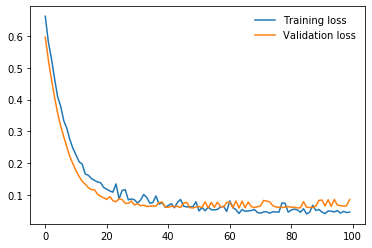

In [52]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

#### The Validation loss levels off around 50 epochs - so set this to avoid overfitting by the training data

In [58]:

# specify an output path
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(# sagemaker details
                    sagemaker_session = sagemaker_session,
                    role = role,
                    output_path = output_path,
                    train_instance_count=1,
                    train_instance_type='ml.c4.xlarge',
    
                    # model source details
                    entry_point = 'train.py', 
                    framework_version='1.0', 
                    source_dir='nnSource', 
                    hyperparameters={'input_features':10, # number of variables
                                    'hidden_dim':15,
                                    'output_dim':1,
                                    'batch-size': 64,
                                    'lr': 0.003,
                                    'epochs': 50
                                    }
                    
                    )

In [60]:
%%time

# Train your estimator on S3 training data
estimator.fit({'train': input_data})

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-11 18:04:31 Starting - Starting the training job...
2020-10-11 18:04:33 Starting - Launching requested ML instances......
2020-10-11 18:05:33 Starting - Preparing the instances for training...
2020-10-11 18:06:31 Downloading - Downloading input data...
2020-10-11 18:06:57 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-10-11 18:06:59,287 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-10-11 18:06:59,290 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-10-11 18:06:59,303 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-10-11 18:07:00,755 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-10-11 18:07:01,193 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.p

#### Deploy the trained model

In [63]:
%%time

from sagemaker.pytorch import PyTorchModel


# deploy your model to create a predictor
model = PyTorchModel(# sagemaker details
                    role = role,
                    # model details
                    framework_version='1.0',
                    model_data = estimator.model_data,
                    source_dir = 'nnSource',
                    entry_point = 'predict.py')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 53.6 ms


In [64]:
%%time
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

'create_image_uri' will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


---------------!CPU times: user 401 ms, sys: 34.3 ms, total: 435 ms
Wall time: 7min 33s


#### Evaluating the model

In [65]:
# read in test data, assuming it is stored locally
train_data = pd.read_csv(os.path.join(data_dir, "nntrain.csv"), header=None, names=None)

# labels are in the first column
train_y = train_data.iloc[:,0]
train_x = train_data.iloc[:,1:]

In [66]:
# read in test data, assuming it is stored locally
test_data = pd.read_csv(os.path.join(data_dir, "nntest.csv"), header=None, names=None)

# labels are in the first column
test_y = test_data.iloc[:,0]
test_x = test_data.iloc[:,1:]

use the training data as a robustness check

In [67]:
train_y_preds = np.squeeze(np.round(predictor.predict(train_x)))
train_y_preds

array([0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
       0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
       0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0.,
       1., 1., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 1., 0.

In [68]:
# returns a variety of model metrics
def evaluate(test_preds, test_labels,  verbose=True):
    """
    Evaluate a model on a test set given the prediction endpoint outcomes.  
    Return binary classification metrics.
    :param test_preds: A prediction endpoint output as a dataframe
    :param test_labels: Class labels for test data as a dataframe
    :param verbose: If True, prints a table of all performance metrics
    :return: A dictionary of performance metrics.
    """
    
    # calculate true positives, false positives, true negatives, false negatives
    tp = np.logical_and(test_labels, test_preds).sum()
    fp = np.logical_and(1-test_labels, test_preds).sum()
    tn = np.logical_and(1-test_labels, 1-test_preds).sum()
    fn = np.logical_and(test_labels, 1-test_preds).sum()
    
    # calculate binary classification metrics
    recall = tp / (tp + fn)
    precision = tp / (tp + fp)
    accuracy = (tp + tn) / (tp + fp + tn + fn)
    
    # printing a table of metrics
    if verbose:
        print(pd.crosstab(test_labels, test_preds, rownames=['actual (row)'], colnames=['prediction (col)']))
        print("\n{:<11} {:.3f}".format('Recall:', recall))
        print("{:<11} {:.3f}".format('Precision:', precision))
        print("{:<11} {:.3f}".format('Accuracy:', accuracy))
        print()
        
    return {'TP': tp, 'FP': fp, 'FN': fn, 'TN': tn, 
            'Precision': precision, 'Recall': recall, 'Accuracy': accuracy}

In [69]:
print('Train Metrics Neural Network Model.\n')

# get metrics for neural net predictor
metrics = evaluate(train_y_preds, 
                   train_y, 
                   verbose=True) # verbose means we'll print out the metrics

Train Metrics Neural Network Model.

prediction (col)  0.0  1.0
actual (row)              
0.0               247    2
1.0                 4  145

Recall:     0.973
Precision:  0.986
Accuracy:   0.985



use the test data for model performance

In [70]:
test_y_preds = np.squeeze(np.round(predictor.predict(test_x)))

In [71]:
print('Test Metrics Neural Network Model.\n')

# get metrics for neural net predictor
metrics = evaluate(test_y_preds, 
                   test_y, 
                   verbose=True) # verbose means we'll print out the metrics

Test Metrics Neural Network Model.

prediction (col)  0.0  1.0
actual (row)              
0.0               108    0
1.0                 2   61

Recall:     0.968
Precision:  1.000
Accuracy:   0.988



#### Delete the endpoint

In [72]:
# Deletes a precictor.endpoint
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [73]:
delete_endpoint(predictor)

Deleted sagemaker-pytorch-2020-10-11-18-14-37-985
